In [21]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3
import importlib.util
import ast
import numpy as np
import networkx as nx
from scipy.stats import poisson

from dotenv import load_dotenv

In [2]:
# Environment setup for cross-compatibility
from scripts_support.lab_cross_compatibility import setup_environment, is_jupyterlite

# Set up environment-specific paths
DATA_DIR, RESULTS_DIR = setup_environment()

# Now you can use DATA_DIR and RESULTS_DIR consistently across environments


Loaded environment variables from: /home/davenport/computational_genetic_genealogy/.env
Working Directory: /home/davenport/computational_genetic_genealogy
Data Directory: /home/davenport/computational_genetic_genealogy/data
References Directory: /home/davenport/computational_genetic_genealogy/references
Results Directory: /home/davenport/computational_genetic_genealogy/results
Utils Directory: /home/davenport/computational_genetic_genealogy/utils
The current directory is /home/davenport/computational_genetic_genealogy


ERSA λ
from Equation 8

$$(a(rd+c))/2^{d−1} \cdot p(t)$$

In [10]:
# Use the table from Kong et al., 2002 to get the total autosomal genetic length
# Enter the value using digits and decimals only (i.e., no commas)
# This value is in centiMorgans (cM)
genome_length = 3435.71
# In your futher developed code, you should calculate the input_value
# for the genome_length from your recombination map.

# Looking at the lambda equation from Equation 8 from the ERSA paper
num_anc = 2  # a: number of ancestors. Enter your choice of 1 or 2

num_rec = genome_length / 100 # r: approximate number of recombination events per meiosis
# Note: The genome_length unit of measurement is cM. One Morgan (M) is 100 cM.
# The definition of a Morgan is the space where at least one recombination event will occur.
# Therefore, we divide our cM value by 100 cM because, on average, 1 recombination event
# will occur every 100 cM or 1 M.

num_chr = 22  # c: number of autosomes in humans

min_seg_len = 3 # t: minimum detectable segment length in cM

d = 6  # d: meiotic distance between individuals in a pair. Enter value of choice.

The probability of a segment being longer than the threshold

$$p(t)= e^{-dt/100}$$

Recall that the following

$$e^x$$

is coded as follows:

```
import numpy as np

np.exp(x)
```



In [11]:
prob_greater_than_t = np.exp(-d * min_seg_len / 100)
print(prob_greater_than_t)

0.835270211411272


Lambda mean is the mean number of segments shared.


$$λ = (a(rd+c))/2^{d−1} \cdot p(t)$$

In [12]:
lambda_mean = ((num_anc * (num_rec * d + num_chr)) / (2 ** (d - 1))) * prob_greater_than_t
print(lambda_mean)

11.91004485836983


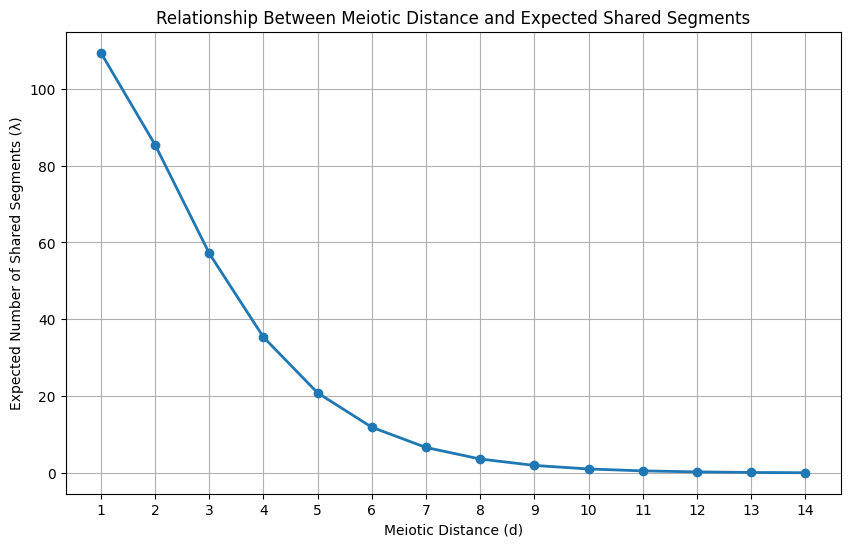

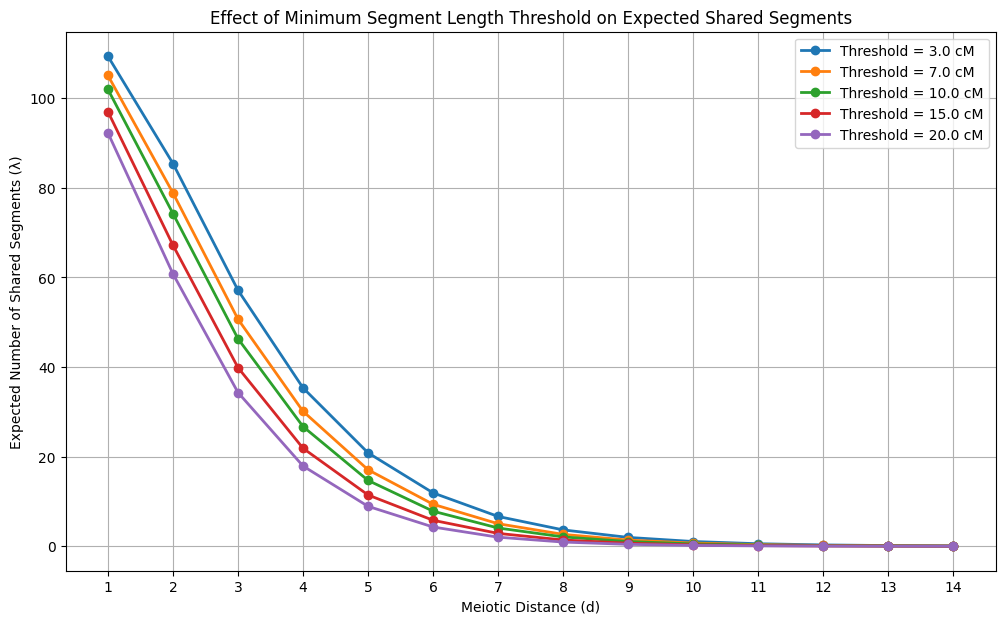

In [14]:
# Understanding genetic recombination and meiotic distance
# Let's explore how changing the meiotic distance affects the expected number of shared segments

meiotic_distances = range(1, 15)  # d values from 1 to 14
lambda_values = []

for d_val in meiotic_distances:
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    lambda_values.append(lambda_val)

plt.figure(figsize=(10, 6))
plt.plot(meiotic_distances, lambda_values, 'o-', linewidth=2)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Number of Shared Segments (λ)')
plt.title('Relationship Between Meiotic Distance and Expected Shared Segments')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.show()

# Let's also see how this relationship is affected by the minimum segment length threshold
thresholds = [3.0, 7.0, 10.0, 15.0, 20.0]  # Different minimum segment length thresholds
plt.figure(figsize=(12, 7))

for threshold in thresholds:
    lambda_values = []
    for d_val in meiotic_distances:
        prob_t = np.exp(-d_val * threshold / 100)
        lambda_val = ((num_anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
        lambda_values.append(lambda_val)
    plt.plot(meiotic_distances, lambda_values, 'o-', linewidth=2, label=f'Threshold = {threshold} cM')

plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Number of Shared Segments (λ)')
plt.title('Effect of Minimum Segment Length Threshold on Expected Shared Segments')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.legend()
plt.show()

### Exploring the Poisson distribution for segment sharing

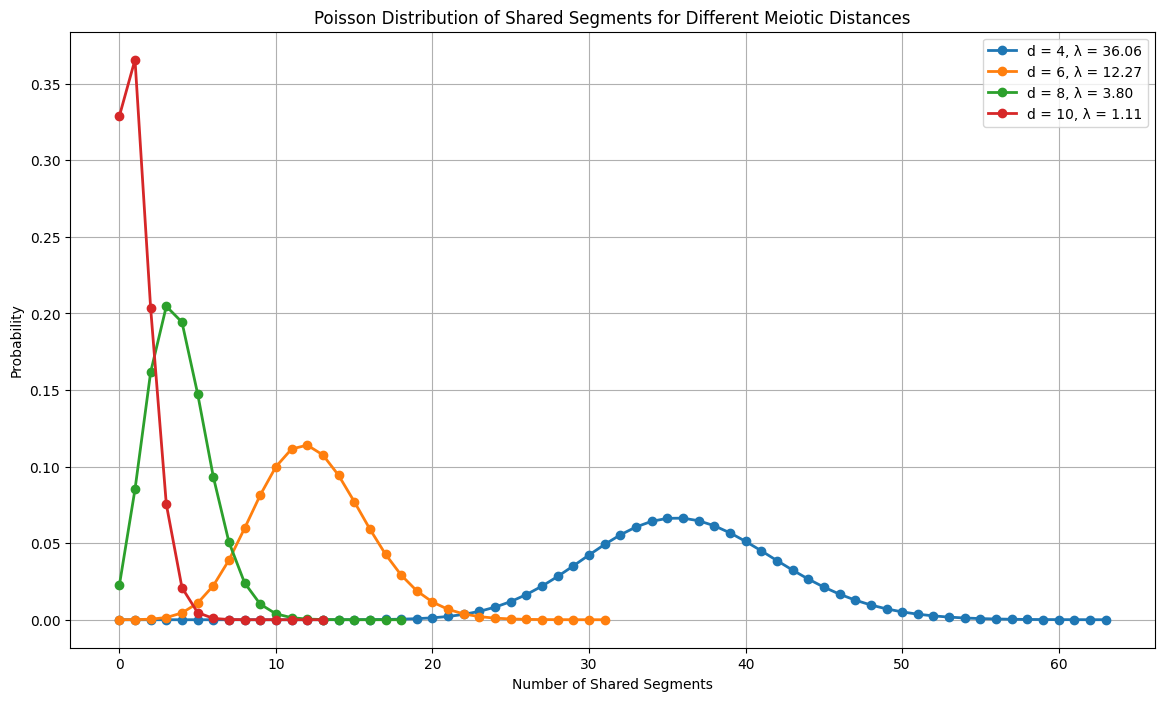

In [22]:
# Let's visualize how the Poisson distribution changes with different meiotic distances
d_values = [4, 6, 8, 10]
plt.figure(figsize=(14, 8))

for d_val in d_values:
    # Calculate lambda for this meiotic distance
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    
    # Create a range of segment count values for this lambda
    max_segments = int(lambda_val + 3 * np.sqrt(lambda_val)) + 10
    segment_counts = np.arange(0, max_segments)
    
    # Calculate Poisson PMF values
    pmf_values = poisson.pmf(segment_counts, lambda_val)
    
    # Plot the distribution
    plt.plot(segment_counts, pmf_values, 'o-', linewidth=2, 
             label=f'd = {d_val}, λ = {lambda_val:.2f}')

plt.xlabel('Number of Shared Segments')
plt.ylabel('Probability')
plt.title('Poisson Distribution of Shared Segments for Different Meiotic Distances')
plt.grid(True)
plt.legend()
plt.show()

### Exploring the relationship between ancestry and expected segments

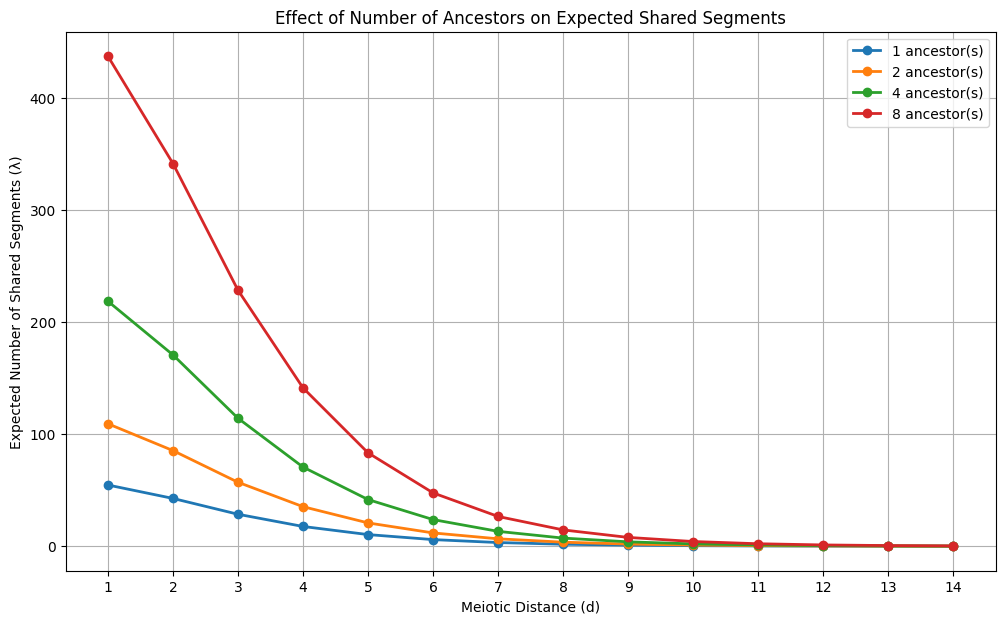

In [15]:
# Effect of number of ancestors on expected IBD segments
ancestor_values = [1, 2, 4, 8]  # Different possible values for num_anc
plt.figure(figsize=(12, 7))

for anc in ancestor_values:
    lambda_values = []
    for d_val in meiotic_distances:
        prob_t = np.exp(-d_val * min_seg_len / 100)
        lambda_val = ((anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
        lambda_values.append(lambda_val)
    plt.plot(meiotic_distances, lambda_values, 'o-', linewidth=2, label=f'{anc} ancestor(s)')

plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Number of Shared Segments (λ)')
plt.title('Effect of Number of Ancestors on Expected Shared Segments')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.legend()
plt.show()

### Exploring the exponential distribution of segment lengths

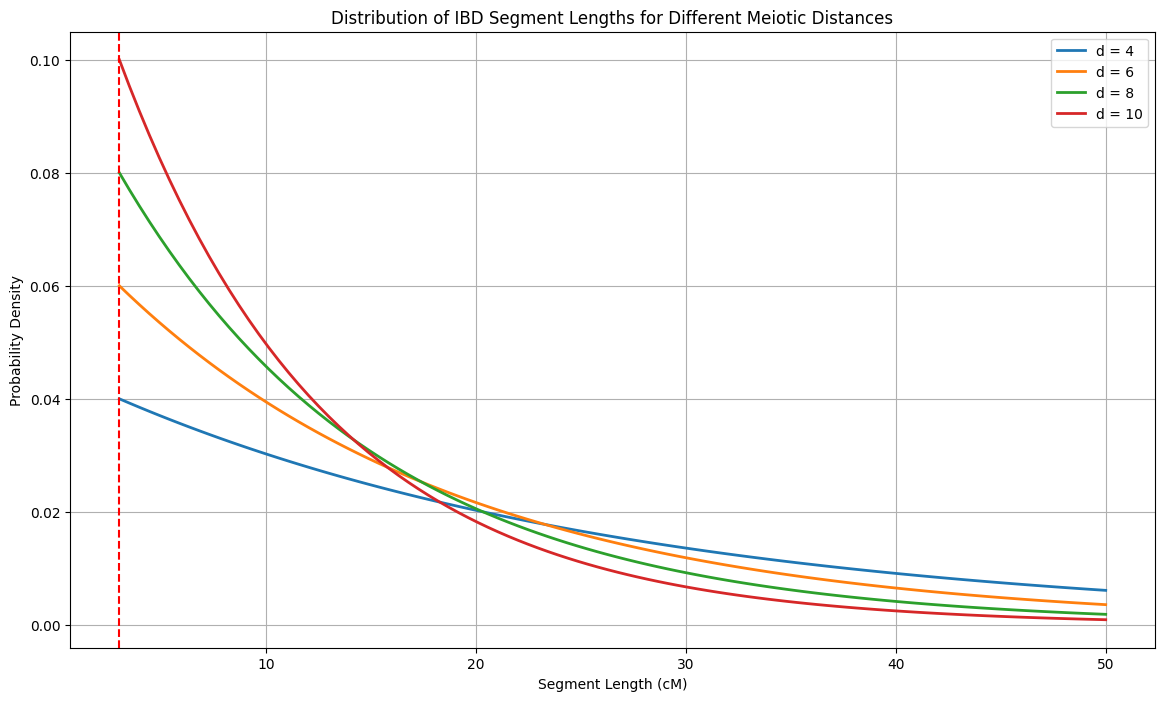

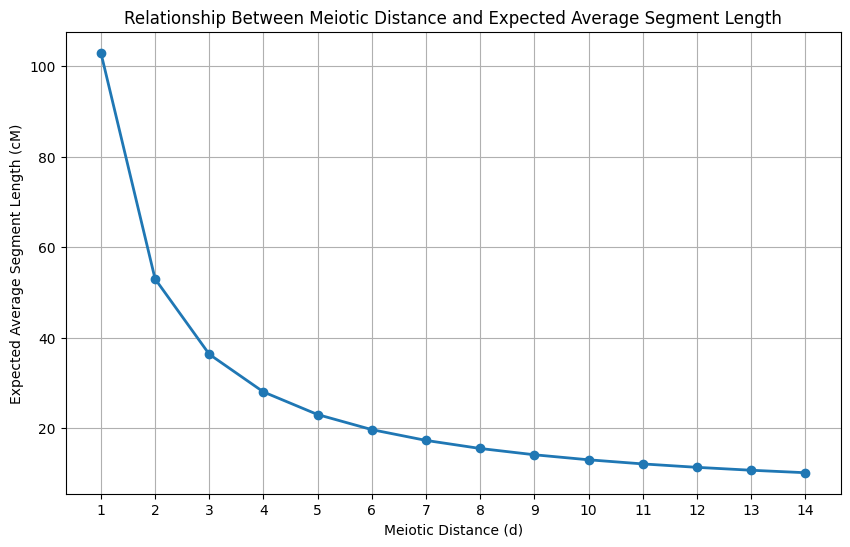

In [16]:
# Let's explore how meiotic distance affects the distribution of segment lengths
d_values = [4, 6, 8, 10]
plt.figure(figsize=(14, 8))

# Use fewer points for a cleaner visualization
length_range_plot = np.linspace(min_seg_len, 50, 100)

for d_val in d_values:
    # Calculate the segment length distribution
    length_distribution = np.exp(-d_val * (length_range_plot - min_seg_len) / 100) / (100 / d_val)
    
    # Plot the distribution
    plt.plot(length_range_plot, length_distribution, linewidth=2, 
             label=f'd = {d_val}')

plt.xlabel('Segment Length (cM)')
plt.ylabel('Probability Density')
plt.title('Distribution of IBD Segment Lengths for Different Meiotic Distances')
plt.grid(True)
plt.legend()
plt.axvline(x=min_seg_len, color='r', linestyle='--', label='Minimum threshold')
plt.show()

# Now let's calculate the expected average segment length for different meiotic distances
avg_lengths = []
for d_val in meiotic_distances:
    # The expected average length is 100/d + minimum threshold
    avg_length = 100/d_val + min_seg_len
    avg_lengths.append(avg_length)

plt.figure(figsize=(10, 6))
plt.plot(meiotic_distances, avg_lengths, 'o-', linewidth=2)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Average Segment Length (cM)')
plt.title('Relationship Between Meiotic Distance and Expected Average Segment Length')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.show()

### Simulating segment sharing between relatives

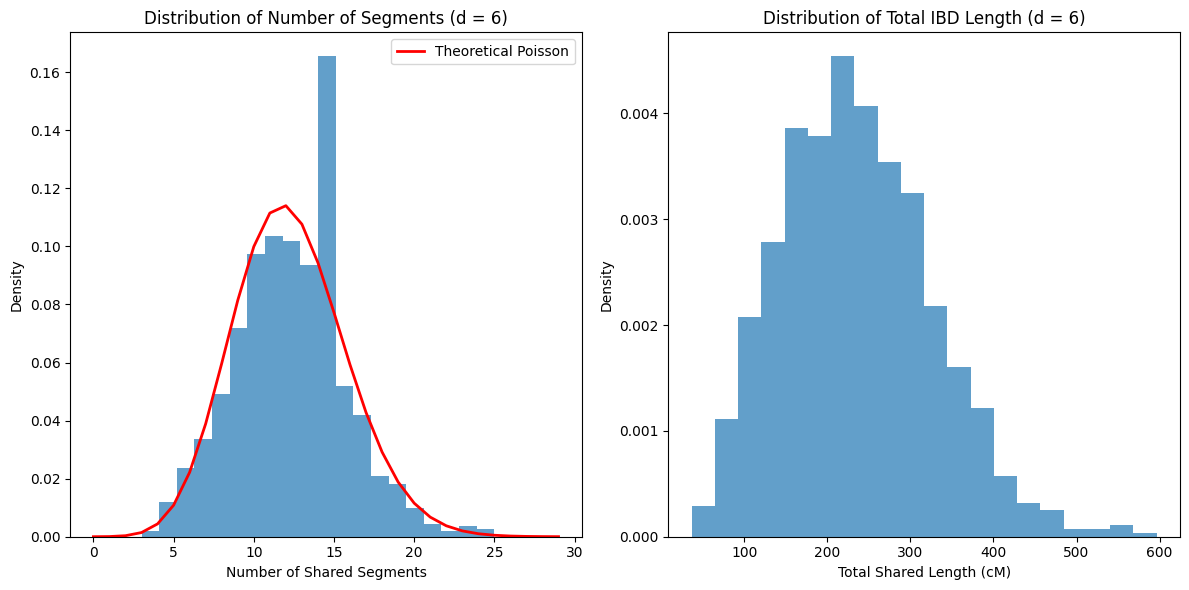

In [23]:
# Let's simulate the sharing of IBD segments between relatives
def simulate_ibd_segments(d, min_length, num_ancestors, num_simulations=1000):
    """
    Simulate the number and total length of IBD segments shared between relatives.
    
    Parameters:
    d: meiotic distance
    min_length: minimum detectable segment length in cM
    num_ancestors: number of shared ancestors
    num_simulations: number of simulations to run
    
    Returns:
    segment_counts: array of number of segments in each simulation
    total_lengths: array of total length of segments in each simulation
    """
    # Calculate lambda (expected number of segments pre-filtering)
    lambda_pre = ((num_ancestors * (num_rec * d + num_chr)) / (2 ** (d - 1)))
    
    segment_counts = []
    total_lengths = []
    
    for _ in range(num_simulations):
        # Sample number of pre-filtered segments from Poisson
        num_segments_pre = np.random.poisson(lambda_pre)
        
        # For each segment, sample its length from exponential distribution
        segment_lengths = np.random.exponential(100/d, num_segments_pre)
        
        # Keep only segments above threshold
        kept_segments = segment_lengths[segment_lengths >= min_length]
        
        # Record results
        segment_counts.append(len(kept_segments))
        total_lengths.append(sum(kept_segments))
    
    return np.array(segment_counts), np.array(total_lengths)

# Run simulations for a specific relationship
d_sim = 6  # Example: first cousins have d = 6
counts, lengths = simulate_ibd_segments(d_sim, min_seg_len, num_anc)

# Visualize the distribution of the number of segments
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(counts, bins=20, alpha=0.7, density=True)
plt.xlabel('Number of Shared Segments')
plt.ylabel('Density')
plt.title(f'Distribution of Number of Segments (d = {d_sim})')

# Calculate the theoretical Poisson PMF for comparison
prob_t = np.exp(-d_sim * min_seg_len / 100)
lambda_val = ((num_anc * (num_rec * d_sim + num_chr)) / (2 ** (d_sim - 1))) * prob_t
count_range = np.arange(0, max(counts) + 5)
poisson_pmf = poisson.pmf(count_range, lambda_val)
plt.plot(count_range, poisson_pmf, 'r-', linewidth=2, label='Theoretical Poisson')
plt.legend()

# Visualize the distribution of total length
plt.subplot(1, 2, 2)
plt.hist(lengths, bins=20, alpha=0.7, density=True)
plt.xlabel('Total Shared Length (cM)')
plt.ylabel('Density')
plt.title(f'Distribution of Total IBD Length (d = {d_sim})')
plt.tight_layout()
plt.show()

### Comparing the Bonsai algorithm implementation with ERSA

                      Relationship  Meiotic Distance     ERSA λ   Bonsai λ  \
0                    First cousins                 4  18.032098  18.032098   
1                   Second cousins                 6   6.136380   6.136380   
2                    Third cousins                 8   1.898795   1.898795   
3                 Great-aunt/uncle                 4  18.032098  18.032098   
4  Half-first cousins once removed                 6  12.272760  12.272760   

   Difference  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  


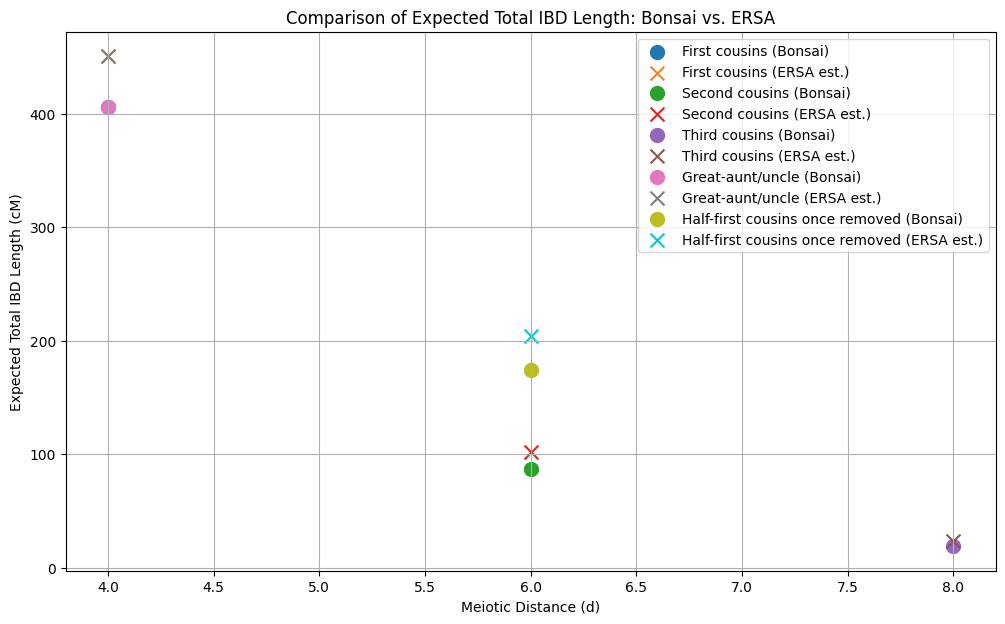

In [24]:
# Let's analyze the Bonsai code snippet and compare it with ERSA equations
# First, implement the Bonsai get_analytical_distant_relative_distribution function

def get_analytical_distant_relative_distribution(relation_tuple, genome_length, min_seg_len):
    """
    Python implementation of the Bonsai function to compare with ERSA equations.
    """
    up_meioses = relation_tuple[0]
    down_meioses = relation_tuple[1]
    num_ancestors = relation_tuple[2]

    num_recs_per_gen = genome_length / 100

    g = up_meioses + down_meioses

    expected_mean_k = (
        num_ancestors * (num_recs_per_gen * g + 22) * (1 / (2 ** (g - 1)))
    )

    p_obs = np.exp(
        -g * min_seg_len / 100
    )  # Probability that a segment is observed, given that the minimum IBD length is min_seg_len

    # The number of shared segments is reduced by the probability that a segment is observed
    k_mean_1 = expected_mean_k * p_obs

    k_std_1 = np.sqrt(k_mean_1)

    threshold = min_seg_len

    T_mean_1 = (100 / g - threshold) * k_mean_1

    T_std_1 = (100 / g) * np.sqrt(2 * k_mean_1)  # From the law of total variance

    T_mean_2, T_std_2 = (0, 5)  # Parameters for background IBD2

    return (k_mean_1, k_std_1, T_mean_1, T_std_1, T_mean_2, T_std_2)

# Let's compare Bonsai implementation with ERSA equations for various relationships
relationships = [
    # (up_meioses, down_meioses, num_ancestors, description)
    (2, 2, 1, "First cousins"),
    (3, 3, 1, "Second cousins"),
    (4, 4, 1, "Third cousins"),
    (1, 3, 1, "Great-aunt/uncle"),
    (4, 2, 2, "Half-first cousins once removed")
]

results = []
for rel in relationships:
    up, down, anc, desc = rel
    
    # Calculate meiotic distance
    d_val = up + down
    
    # Calculate ERSA expected number of segments
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_ersa = ((anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    
    # Get Bonsai parameters
    bonsai_params = get_analytical_distant_relative_distribution((up, down, anc), genome_length, min_seg_len)
    lambda_bonsai = bonsai_params[0]
    
    # Store results
    results.append({
        'Relationship': desc,
        'Meiotic Distance': d_val,
        'ERSA λ': lambda_ersa,
        'Bonsai λ': lambda_bonsai,
        'Difference': lambda_bonsai - lambda_ersa
    })

# Display results as a table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Let's compare how the two methods model the total IBD length
plt.figure(figsize=(12, 7))

for rel in relationships:
    up, down, anc, desc = rel
    d_val = up + down
    
    # Calculate Bonsai parameters
    bonsai_params = get_analytical_distant_relative_distribution((up, down, anc), genome_length, min_seg_len)
    k_mean = bonsai_params[0]
    T_mean = bonsai_params[2]
    
    # Calculate ERSA expected total length
    # ERSA doesn't provide a direct formula for expected total length,
    # but we can estimate it using the average segment length formula from the paper
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_ersa = ((anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    avg_length_ersa = (100 / d_val)  # Average length given by Equation 7
    T_mean_ersa = lambda_ersa * avg_length_ersa
    
    plt.scatter(d_val, T_mean, label=f"{desc} (Bonsai)", marker='o', s=100)
    plt.scatter(d_val, T_mean_ersa, label=f"{desc} (ERSA est.)", marker='x', s=100)

plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('Comparison of Expected Total IBD Length: Bonsai vs. ERSA')
plt.grid(True)
plt.legend()
plt.show()

### Understanding the relationship between genetic distance and genealogical relationships

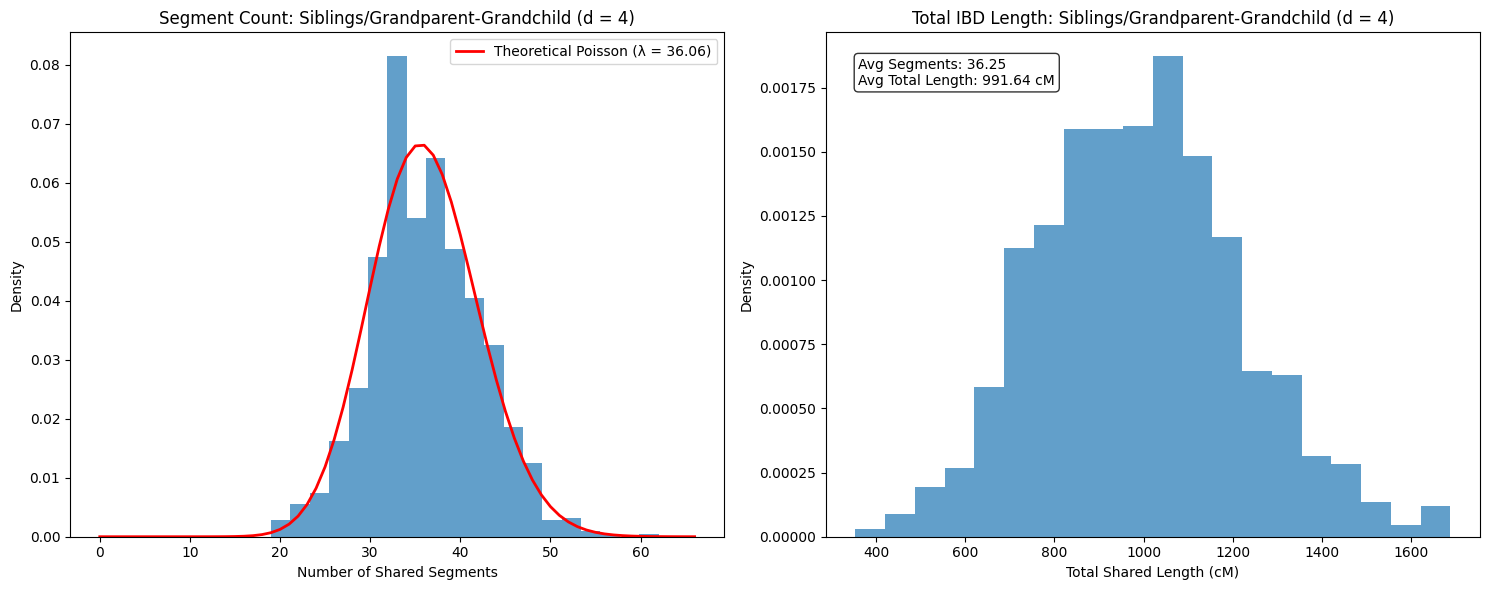

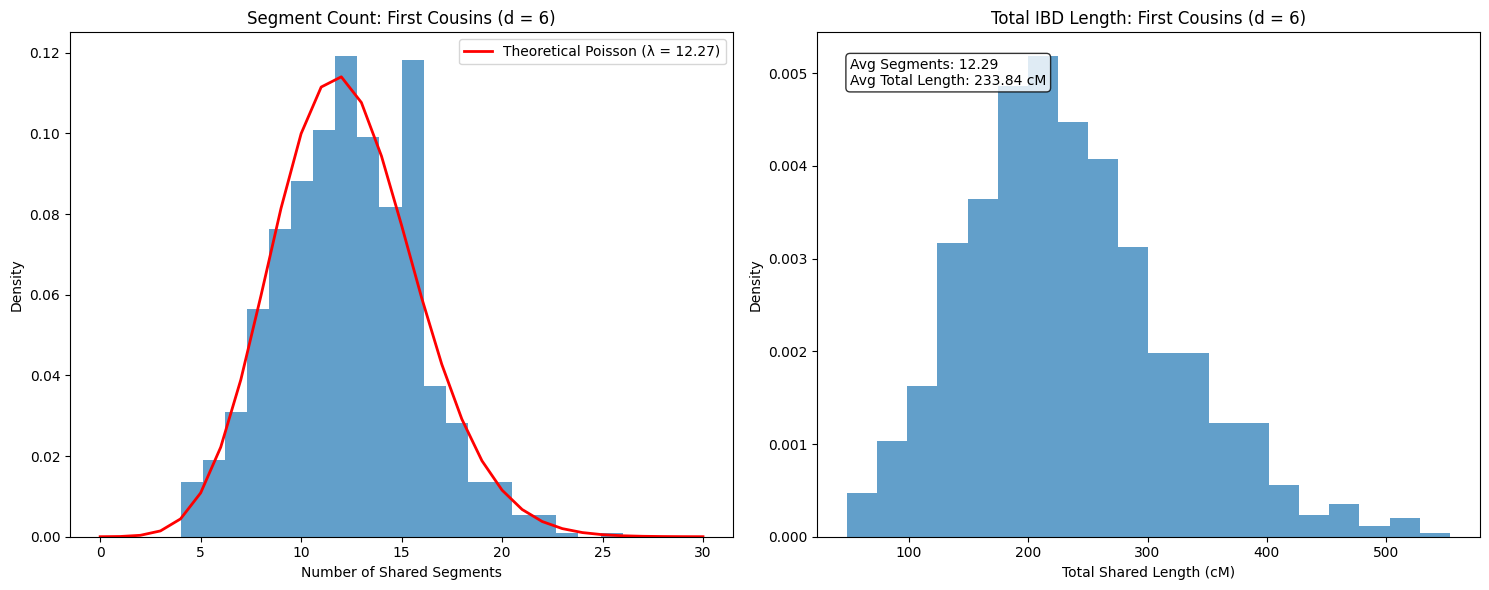

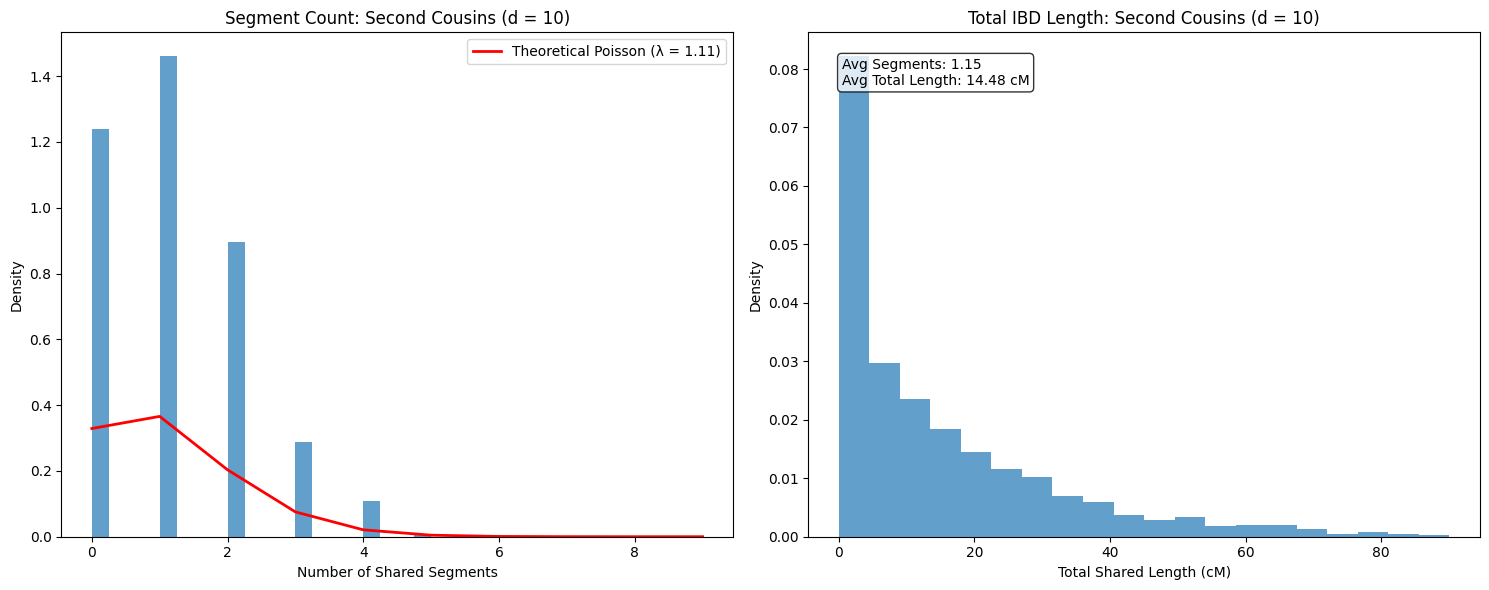

                      Relationship  Meiotic Distance  Expected Segments  \
0  Siblings/Grandparent-Grandchild                 4          36.064195   
1                    First Cousins                 6          12.272760   
2                   Second Cousins                10           1.112137   

   Simulated Avg Segments  Simulated Avg Length  
0                  36.247            991.642786  
1                  12.287            233.842891  
2                   1.147             14.475676  


In [25]:
# Convert meiotic distance to genealogical relationship
relationship_dict = {
    2: "Parent-Child",
    4: "Siblings, Grandparent-Grandchild",
    5: "Half-Siblings, Aunt/Uncle-Niece/Nephew",
    6: "First Cousins",
    8: "First Cousins Once Removed",
    10: "Second Cousins",
    12: "Second Cousins Once Removed",
    14: "Third Cousins"
}

# Create a function to simulate segments and visualize results for a specific relationship
def simulate_and_visualize_relationship(d, description, min_seg_len=2.5, num_anc=2, num_sims=1000):
    """
    Simulate IBD segments and visualize distributions for a specific relationship
    """
    # Calculate expected lambda
    prob_t = np.exp(-d * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d + num_chr)) / (2 ** (d - 1))) * prob_t
    
    # Simulate segments
    counts, lengths = simulate_ibd_segments(d, min_seg_len, num_anc, num_sims)
    
    # Create visualizations
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot segment count distribution
    axs[0].hist(counts, bins=20, alpha=0.7, density=True)
    axs[0].set_xlabel('Number of Shared Segments')
    axs[0].set_ylabel('Density')
    axs[0].set_title(f'Segment Count: {description} (d = {d})')
    
    # Add theoretical Poisson curve
    count_range = np.arange(0, max(counts) + 5)
    poisson_pmf = poisson.pmf(count_range, lambda_val)
    axs[0].plot(count_range, poisson_pmf, 'r-', linewidth=2, 
                label=f'Theoretical Poisson (λ = {lambda_val:.2f})')
    axs[0].legend()
    
    # Plot total length distribution
    axs[1].hist(lengths, bins=20, alpha=0.7, density=True)
    axs[1].set_xlabel('Total Shared Length (cM)')
    axs[1].set_ylabel('Density')
    axs[1].set_title(f'Total IBD Length: {description} (d = {d})')
    
    # Add summary statistics
    avg_segments = np.mean(counts)
    avg_total_length = np.mean(lengths)
    axs[1].text(0.05, 0.95, f'Avg Segments: {avg_segments:.2f}\nAvg Total Length: {avg_total_length:.2f} cM', 
                transform=axs[1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        "Relationship": description,
        "Meiotic Distance": d,
        "Expected Segments": lambda_val,
        "Simulated Avg Segments": avg_segments,
        "Simulated Avg Length": avg_total_length
    }

# Simulate a few important relationships
results = []
for d, desc in [(4, "Siblings/Grandparent-Grandchild"), 
                (6, "First Cousins"), 
                (10, "Second Cousins")]:
    result = simulate_and_visualize_relationship(d, desc)
    results.append(result)

# Display results table
results_df = pd.DataFrame(results)
print(results_df)

### Understanding the Bonsai algorithm better

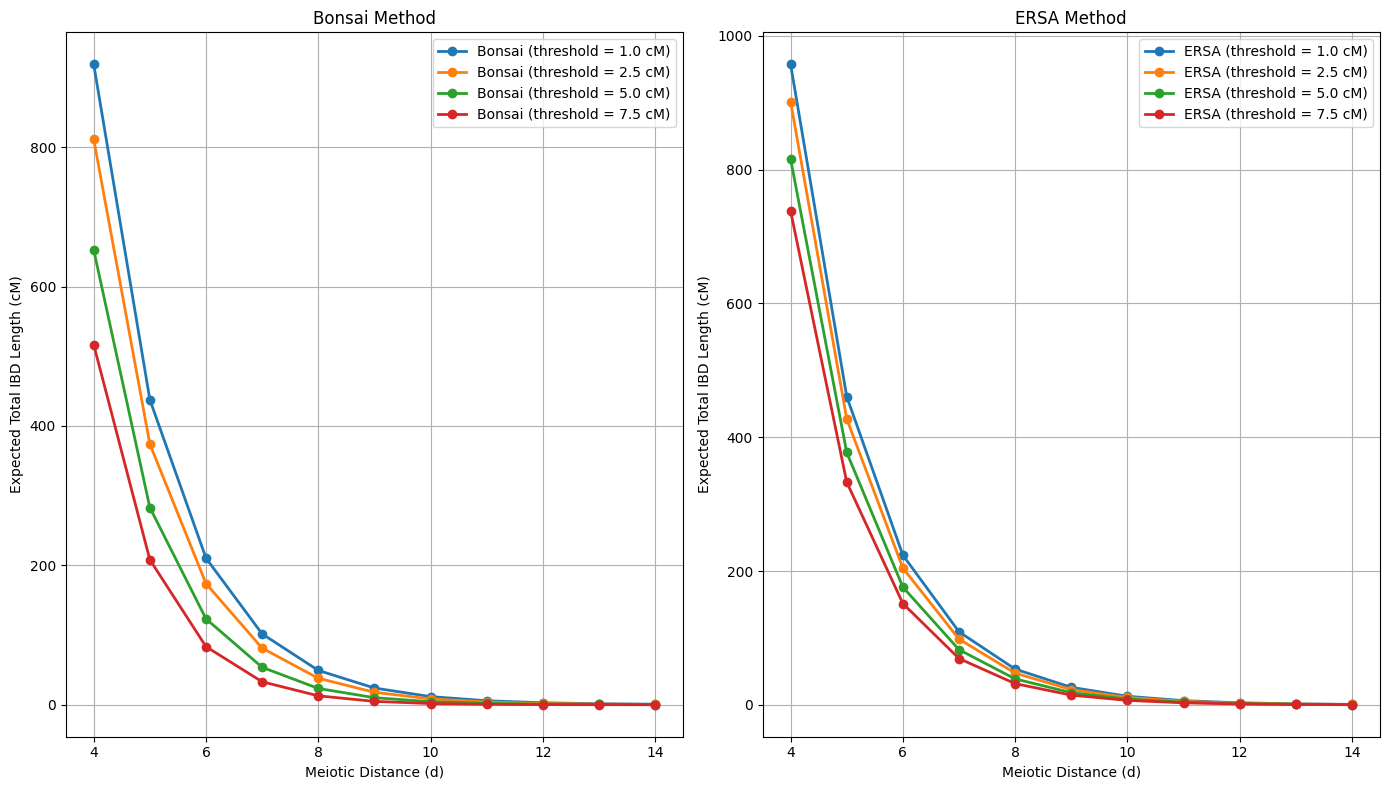

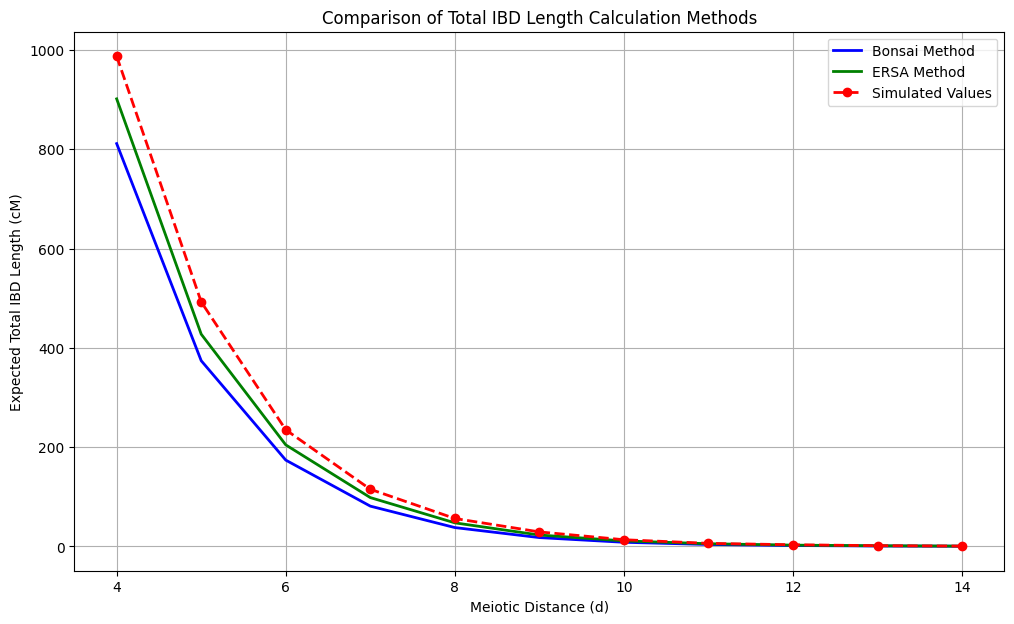

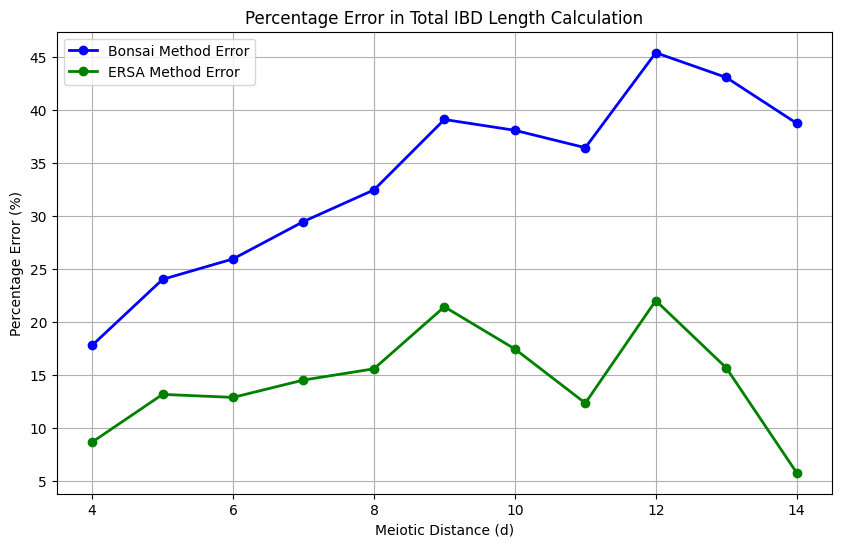

In [26]:
# Let's explore the Bonsai expected total length formula: T_mean_1 = (100 / g - threshold) * k_mean_1
# and compare it with our understanding from ERSA

meiotic_distances = range(4, 15)
thresholds = [1.0, 2.5, 5.0, 7.5]

plt.figure(figsize=(14, 8))

for threshold in thresholds:
    bonsai_means = []
    ersa_means = []
    
    for d in meiotic_distances:
        # Calculate parameters
        prob_t = np.exp(-d * threshold / 100)
        lambda_val = ((num_anc * (num_rec * d + num_chr)) / (2 ** (d - 1))) * prob_t
        
        # Bonsai method
        bonsai_mean = (100 / d - threshold) * lambda_val
        bonsai_means.append(bonsai_mean)
        
        # ERSA method (estimated)
        ersa_mean = (100 / d) * lambda_val
        ersa_means.append(ersa_mean)
    
    plt.subplot(1, 2, 1)
    plt.plot(meiotic_distances, bonsai_means, 'o-', linewidth=2, 
             label=f'Bonsai (threshold = {threshold} cM)')
    
    plt.subplot(1, 2, 2)
    plt.plot(meiotic_distances, ersa_means, 'o-', linewidth=2, 
             label=f'ERSA (threshold = {threshold} cM)')

plt.subplot(1, 2, 1)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('Bonsai Method')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('ERSA Method')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Let's also analyze why Bonsai uses T_mean_1 = (100/g - threshold) * k_mean_1
# instead of T_mean_1 = (100/g) * k_mean_1 as would be expected from ERSA

d_values = range(4, 15)
min_seg_len = 2.5
num_anc = 2

# Calculate using both methods and compare through simulation
plt.figure(figsize=(12, 7))

# Theoretical calculations
bonsai_means = []
ersa_means = []
simulated_means = []

for d in d_values:
    # Calculate lambda
    prob_t = np.exp(-d * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d + num_chr)) / (2 ** (d - 1))) * prob_t
    
    # Bonsai method
    bonsai_mean = (100 / d - min_seg_len) * lambda_val
    bonsai_means.append(bonsai_mean)
    
    # ERSA method (estimated)
    ersa_mean = (100 / d) * lambda_val
    ersa_means.append(ersa_mean)
    
    # Simulate to get actual mean (limited simulations for speed)
    _, lengths = simulate_ibd_segments(d, min_seg_len, num_anc, 500)
    simulated_means.append(np.mean(lengths))

plt.plot(d_values, bonsai_means, 'b-', linewidth=2, label='Bonsai Method')
plt.plot(d_values, ersa_means, 'g-', linewidth=2, label='ERSA Method')
plt.plot(d_values, simulated_means, 'ro--', linewidth=2, label='Simulated Values')
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('Comparison of Total IBD Length Calculation Methods')
plt.grid(True)
plt.legend()
plt.show()

# Analyze which method is more accurate by calculating the percentage error
bonsai_errors = []
ersa_errors = []

for i, d in enumerate(d_values):
    bonsai_error = abs(bonsai_means[i] - simulated_means[i]) / simulated_means[i] * 100
    ersa_error = abs(ersa_means[i] - simulated_means[i]) / simulated_means[i] * 100
    
    bonsai_errors.append(bonsai_error)
    ersa_errors.append(ersa_error)

plt.figure(figsize=(10, 6))
plt.plot(d_values, bonsai_errors, 'bo-', linewidth=2, label='Bonsai Method Error')
plt.plot(d_values, ersa_errors, 'go-', linewidth=2, label='ERSA Method Error')
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Percentage Error (%)')
plt.title('Percentage Error in Total IBD Length Calculation')
plt.grid(True)
plt.legend()
plt.show()

So now we have our mean, Poison-distributed, number of segments shared between a pair, given the parameter values.

According to the ERSA paper, the number of segments for meiotic distance has a poisson distribution. The Poisson distribution is a discrete distribution that models the probability of a certain number of events occurring within a fixed interval of time or space.

The formula for the Poisson distribution is known as the probability mass function (PMF). We will use the `poisson.pmf` method from the `scipy.stats` package.

$$poisson.pmf(k, λ)$$

where

k is the number of events (k) = actual number of shared segments in pair

λ is the rate parameter λ

<br>

The Poisson probability mass function `poisson.pmf(k, λ)` gives the probability of observing exactly k shared segments, given the mean λ, where λ represents the relationship among a set of variables.

In [ ]:
from scipy.stats import poisson

# The probability of sharing 0 segment given your parameter values above.

poisson.pmf(0, lambda_mean)

In [ ]:
# The probability of sharing 1 segment given your parameter values above.

poisson.pmf(1, lambda_mean)

In [ ]:
# The probability of sharing 3 segment given your parameter values above.

poisson.pmf(3, lambda_mean)

In [ ]:
# The probability of sharing 5 segment given your parameter values above.

poisson.pmf(5, lambda_mean)

If you want to see the probabilty of sharing 0, 1, 3, and 5 segments given a different set of parameter values, you would need to change your values above and rerun the cells (including the cell where you changed your parameter values).

Rather than plugging values for the number of segments we are interested in one by one, we may be interested in looking at a range of segment number values. This is called our distribution.

<br>

We will create a range based on the mean and standard deviation of the number of segments. Because the number of segments shared is Poisson-distributed, we know that the standard deviation is approximated as the square root of the mean.

In [ ]:
# Using the numpy package, this gives us a range from 0 to a value that is int(lambda_mean) + 3*np.sqrt(lambda_mean)

n_values = np.arange(0, int(lambda_mean) + 3*np.sqrt(lambda_mean))
n_values

In [ ]:
from scipy.stats import poisson

distribution_num_segments = poisson.pmf(n_values, lambda_mean)

# Display the distribution
distribution_num_segments


You can also plot the distribution.

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution
plt.stem(n_values, distribution_num_segments)
plt.xlabel('Number of Shared Segments')
plt.ylabel('Probability')
plt.title('Poisson Distribution of Shared Segments')


# Find the value with the maximum probability
max_prob_n = n_values[np.argmax(distribution_num_segments)]
max_prob = np.max(distribution_num_segments)

# Output the number of shared segments with the maximum probability and its probability
print(f"The maximum probablity is {max_prob} with a segment sharing of {max_prob_n} segments." )

plt.show()

Similarly with equation 7...

In [ ]:
# Equation 7 describes the probability density function of an exponential distribution
# conditioned on a threshold t.

# Range of segment lengths from t to 100 cM
# Containing 1000 evenly spaced points between these two limits
length_range = np.linspace(min_seg_len, 100, 1000)

# Calculate the probability density function values for the range of segment lengths i
# conditioned on the threshold t
length_size_distribution = np.exp(-d * (length_range - min_seg_len) / 100) / (100 / d)

length_size_distribution

In [ ]:
# Now let's plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(length_range, length_size_distribution, label=f'length distribution, given meiotic distance = {d}, minimum threshold = {min_seg_len} cM)')
plt.xlabel('Segment Length (cM)')
plt.ylabel('Probability Density')
plt.title('Conditioned Exponential Distribution of Segment Lengths')
plt.legend()
plt.grid(True)
plt.show()


### Bonsai snippet

This is a code snippet from the Bonsai algorithm that we will use to infer genetic pedigrees. Can you match the code lines with the ERSA paper?

k_mean_1, the number of segments, is designed to reflect equation 8. What's the same? What's different?

T_mean_1, the average length, doesn't quite look like equation 7. What is it doing?  

In [ ]:
    def get_analytical_distant_relative_distribution(
        self, relation_tuple: Tuple[int, int, int]
    ):
        """
        Get the paramters for the log likelihood using the Huff et al (2011) formula.
        (Equations 7, 8, and the paragraph before Eqn 7). This is for the case when
        two people are related by more than 14 meioses. We do not simulate IBD
        distributions for relationships this distant so we need to use the analytical
        distribution.
        """
        up_meioses = relation_tuple[0]
        down_meioses = relation_tuple[1]
        num_ancestors = relation_tuple[2]

        num_recs_per_gen = genome_length / 100

        g = up_meioses + down_meioses

        expected_mean_k = (
            num_ancestors * (num_recs_per_gen * g + 22) * (1 / (2 ** (g - 1)))
        )


        p_obs = np.exp(
            -g * self.min_seg_len / 100
        )  # Probability that a segment is observed, given that the minimum IBD length is min_seg_len

        # The number of shared segments is reduced by the probability that a segment is observed
        k_mean_1 = expected_mean_k * p_obs

        k_std_1 = np.sqrt(k_mean_1)

        threshold = self.min_seg_len

        """

        # FIX FIX: order of operations.
        # FIX FIX: use equation 7 instead of this

        """
        T_mean_1 = (100 / g - threshold) * k_mean_1

        """
        The standard deviation of the total length (T_std_1) is computed using the square root of
        twice the mean number of shared segments, multiplied by 100/g, based on the law of total variance.
        """
        T_std_1 = (100 / g) * np.sqrt(2 * k_mean_1)  # From the law of total variance

        T_mean_2, T_std_2 = (0, 5)  # Parameters for background IBD2

        return (k_mean_1, k_std_1, T_mean_1, T_std_1, T_mean_2, T_std_2)